In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
import validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import PR_curve
from sklearn.cluster import KMeans

In [2]:
data_dir='fixed_csv_label_ver2'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


In [3]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

df_list=[]
for i in set(df['day']):
    lag=[] 
    window=5
    lag.append(make_data(df.loc[df['day']==i, ['original']], 'original', window))
    lag.append(df.loc[df['day']==i, ['day']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
df=pd.concat(df_list)
df=df.dropna().reset_index(drop=True)
df['d']=0
df['z']=0
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,day,d,z
0,53.6,53.2,52.8,52.8,53.4,0,0,0
1,54.0,53.6,53.2,52.8,52.8,0,0,0
2,54.7,54.0,53.6,53.2,52.8,0,0,0
3,55.7,54.7,54.0,53.6,53.2,0,0,0
4,55.5,55.7,54.7,54.0,53.6,0,0,0
...,...,...,...,...,...,...,...,...
3995305,45.9,45.6,45.4,45.9,46.0,9,0,0
3995306,45.6,45.9,45.6,45.4,45.9,9,0,0
3995307,45.8,45.6,45.9,45.6,45.4,9,0,0
3995308,45.7,45.8,45.6,45.9,45.6,9,0,0


## クロスバリデーション（パラメータチューニング）

In [4]:
cv_data_list=df['day'].unique().tolist()
#テストデータ
test_notvalid=[]
for i in range(len(test_notvalid)):
    #検証データ＋訓練データ
    cv_data_list.remove(test_notvalid[i])
cv_data_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
f_score_sum=0
all_data_list=df['day'].unique().tolist()
for i in cv_data_list:
    print(f'訓練データ：{[k for k in cv_data_list if k!=i]}')
    print(f'検証データ：{i}日目')

    test_day=[i]
    train=df[(~df['day'].isin(test_day))][df.columns[:-3]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-3]].reset_index(drop=True)

    nk = 21
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx

    test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
    test_v['d']=d[0]
    test_v.loc[window-1:, 'd']=d
 
    #kmeans
    n_clusters=2
    model = KMeans(n_clusters=n_clusters)  
    model.fit(d.reshape((-1, 1)))
    clusters = model.predict(d.reshape((-1, 1)))  
    result=pd.DataFrame({'d':d, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = thr_range.quantile(0.25)
    Q3 = thr_range.quantile(0.75)
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(f'閾値{thr}')
    
    d_test=test_v['d'].values
    precision, recall=validate.validate(test_v, d_test, thr)
    f_score=(2*precision*recall)/(precision+recall)
    print(f'適合率：{precision}')
    print(f'再現率：{recall}')
    print(f'f値：{f_score}')
    f_score_sum+=f_score

    z=np.where(d>=thr, 1, 0)
    df.loc[(df['day'].isin(test_day)), 'd']=d
    df.loc[(df['day'].isin(test_day)), 'z']=z
    print('-----------------------------------------------')
f_mean=f_score_sum/len(cv_data_list)
print(f'f値平均：{f_mean}')

訓練データ：[1, 2, 3, 4, 5, 6, 7, 8, 9]
検証データ：0日目
閾値0.18396672088684876
適合率：0.8212237093690249
再現率：0.8717948717948718
f値：0.8457539998552088
-----------------------------------------------
訓練データ：[0, 2, 3, 4, 5, 6, 7, 8, 9]
検証データ：1日目
閾値0.2754407532649631
適合率：0.994535519125683
再現率：0.7209302325581395
f値：0.8359137713904733
-----------------------------------------------
訓練データ：[0, 1, 3, 4, 5, 6, 7, 8, 9]
検証データ：2日目
閾値0.10471147126960484
適合率：0.7962546816479401
再現率：0.8958333333333334
f値：0.8431139270859271
-----------------------------------------------
訓練データ：[0, 1, 2, 4, 5, 6, 7, 8, 9]
検証データ：3日目
閾値0.3685601917390289
適合率：0.934984520123839
再現率：0.5517241379310345
f値：0.6939537555651301
-----------------------------------------------
訓練データ：[0, 1, 2, 3, 5, 6, 7, 8, 9]
検証データ：4日目
閾値0.12928959441787327
適合率：0.9223085460599334
再現率：0.890625
f値：0.9061899159181565
-----------------------------------------------
訓練データ：[0, 1, 2, 3, 4, 6, 7, 8, 9]
検証データ：5日目
閾値0.24128530398474357
適合率：0.9313380281690141
再現率：0.928571428

Text(0, 0.5, '度数')

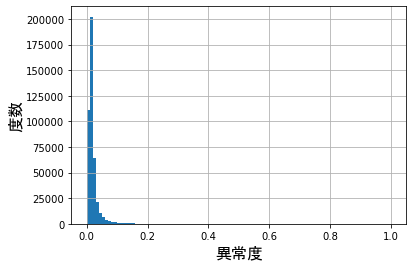

In [9]:
df.loc[df['day']==0, 'd'].hist(bins=100)
plt.xlabel('異常度', fontname="MS Gothic", fontsize=16)
plt.ylabel('度数', fontname="MS Gothic", fontsize=16)

## テストデータの評価

In [ ]:
print(f'訓練データ：{cv_data_list}')
print(f'テストデータ：{test_notvalid[0]}日目')

train=df[(df['day'].isin(cv_data_list))][df.columns[:-3]].reset_index(drop=True)
test=df[(df['day'].isin(test_notvalid))][df.columns[:-3]].reset_index(drop=True)

neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train)
d = neigh.kneighbors(test)[0]
d = np.mean(d, axis=1)
mx = np.max(d)
d = d / mx

test_v=original[original['day'].isin(test_notvalid)][['original', 'label']].reset_index(drop=True)
test_v['d']=d[0]
test_v.loc[window-1:, 'd']=d

#kmeans
n_clusters=2
model = KMeans(n_clusters=n_clusters)  
model.fit(d.reshape((-1, 1)))
clusters = model.predict(d.reshape((-1, 1)))  
result=pd.DataFrame({'d':d, 'cluster':clusters})
thr_list=[]
for j in range(n_clusters):
    thr_list.append(result.loc[result['cluster']==j, 'd'].max())
thr_min=sorted(thr_list)[-2]
thr_max=sorted(thr_list)[-1]
thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
Q1 = thr_range.quantile(0.25)
Q3 = thr_range.quantile(0.75)
IQR = Q3 - Q1
thr = min(float(Q3 + 1.5 * IQR), thr_max)
print(f'閾値{thr}')

d_test=test_v['d'].values
precision, recall=validate.validate(test_v, d_test, thr)
f_score=(2*precision*recall)/(precision+recall)
print(f'適合率：{precision}')
print(f'再現率：{recall}')
print(f'f値：{f_score}')

# kmeansによる閾値

In [ ]:
from sklearn.cluster import KMeans
n_clusters=4
for i in df['day'].unique():
    day=i
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==0, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==0, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
    thr=sorted(thr_list)[-1]
    print(f'{i}日目閾値{thr}')

## kmeans+箱ひげ

In [ ]:
from sklearn.cluster import KMeans
n_clusters=4
for i in df['day'].unique():
    day=i
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==day, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==day, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>=thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = thr_range.quantile(0.25)
    Q3 = thr_range.quantile(0.75)
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(f'{i}日目閾値{thr}')
    

In [ ]:
n_clusters=2
for i in df['day'].unique():
    day=i
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==day, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==day, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>=thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = thr_range.quantile(0.25)
    Q3 = thr_range.quantile(0.75)
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(f'{i}日目閾値{thr}')

In [ ]:
from sklearn.cluster import KMeans
n_clusters=4
for i in df['day'].unique():
    day=i
    d_df=df.loc[df['day']==day, ['d']].copy()
    d_sample=d_df.sample(n=54000)
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(d_sample.values)
    clusters = model.predict(d_sample.values)  
    result=pd.DataFrame({'d':d_sample.values.flatten(), 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
        
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>=thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = thr_range.quantile(0.25)
    Q3 = thr_range.quantile(0.75)
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(f'{i}日目閾値{thr}')

In [ ]:
n_clusters=2
for i in df['day'].unique():
    day=i
    d_df=df.loc[df['day']==day, ['d']].copy()
    d_sample=d_df.sample(n=len(d_df)-100000)
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(d_sample.values)
    clusters = model.predict(d_sample.values)  
    result=pd.DataFrame({'d':d_sample.values.flatten(), 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
        
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = thr_range.quantile(0.25)
    Q3 = thr_range.quantile(0.75)
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(f'{i}日目閾値{thr}')

In [ ]:
from sklearn.cluster import KMeans
n_clusters=4
for i in df['day'].unique():
    day=i
    d_df=df.loc[df['day']==day, ['d']].copy()
    d_sample=d_df.sample(n=54000)
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(d_sample.values)
    clusters = model.predict(d_sample.values)  
    result=pd.DataFrame({'d':d_sample.values.flatten(), 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
    print(f'{i}日目閾値{sorted(thr_list)[-2]}')

In [ ]:
d_df.hist(bins=1000)
plt.ylim(0, 100)

In [ ]:
day=1
for j  in range(2,8):  
    print(f'{j}クラスタ')
    model = KMeans(n_clusters=j, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==0, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==0, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(j):
        thr_list.append(result.loc[result['cluster']==j, 'd'].min())
    plt.hist(df.loc[df['day']==day, 'd'], bins=500)
    plt.xticks([0, 0.1, 0.2, 0.3, 0.5, sorted(thr_list)[-1]], ["0", "0.1", "0.2", "0.3", "0.5", "thr"])
    plt.xlim(0, 0.5)
    plt.show()

In [ ]:
for i in df['day'].unique():
    day=i
    distortions = []
    print(f'{i}日目')
    for j  in range(2,8):  
        model = KMeans(n_clusters=j, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
        model.fit(df.loc[df['day']==day, ['d']].values)
        distortions.append(model.inertia_)
    plt.plot(range(2,8),distortions,marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
        

In [ ]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                init='k-means++')    # k-means++法によりクラスタ中心を選択

    km.fit(X)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
n_clusters=8
for i in df['day'].unique():
    day=i
    model = KMeans(n_clusters=n_clusters, random_state=0)  # initを省略すると、k-means++法が適応される(randomではk-means法が適応)
    model.fit(df.loc[df['day']==day, ['d']].values)
    clusters = model.predict(df.loc[df['day']==0, ['d']].values)  
    result=pd.DataFrame({'d':df.loc[df['day']==0, 'd'].values, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    print(f'{i}日目閾値\n{sorted(thr_list)}')